In [1]:
import pandas as pd
df = pd.read_csv('/kaggle/input/d/james951/proteindataset/Protein/protein_sequence_classification.csv')
# 统计分类数量并筛选前10
top10_classes = df['classification'].value_counts().head(10).index.tolist()
# 过滤数据，只保留前10类
df_top10 = df[df['classification'].isin(top10_classes)].reset_index(drop=True)
print(f'{len(df_top10)} samples have been filtered，involve classes {top10_classes}') 
sequences = df_top10['sequence'].tolist()
labels_str = df_top10['classification'].tolist()

188353 samples have been filtered，involve classes ['HYDROLASE', 'TRANSFERASE', 'OXIDOREDUCTASE', 'IMMUNE SYSTEM', 'LYASE', 'HYDROLASE/HYDROLASE INHIBITOR', 'TRANSCRIPTION', 'VIRAL PROTEIN', 'TRANSPORT PROTEIN', 'VIRUS']


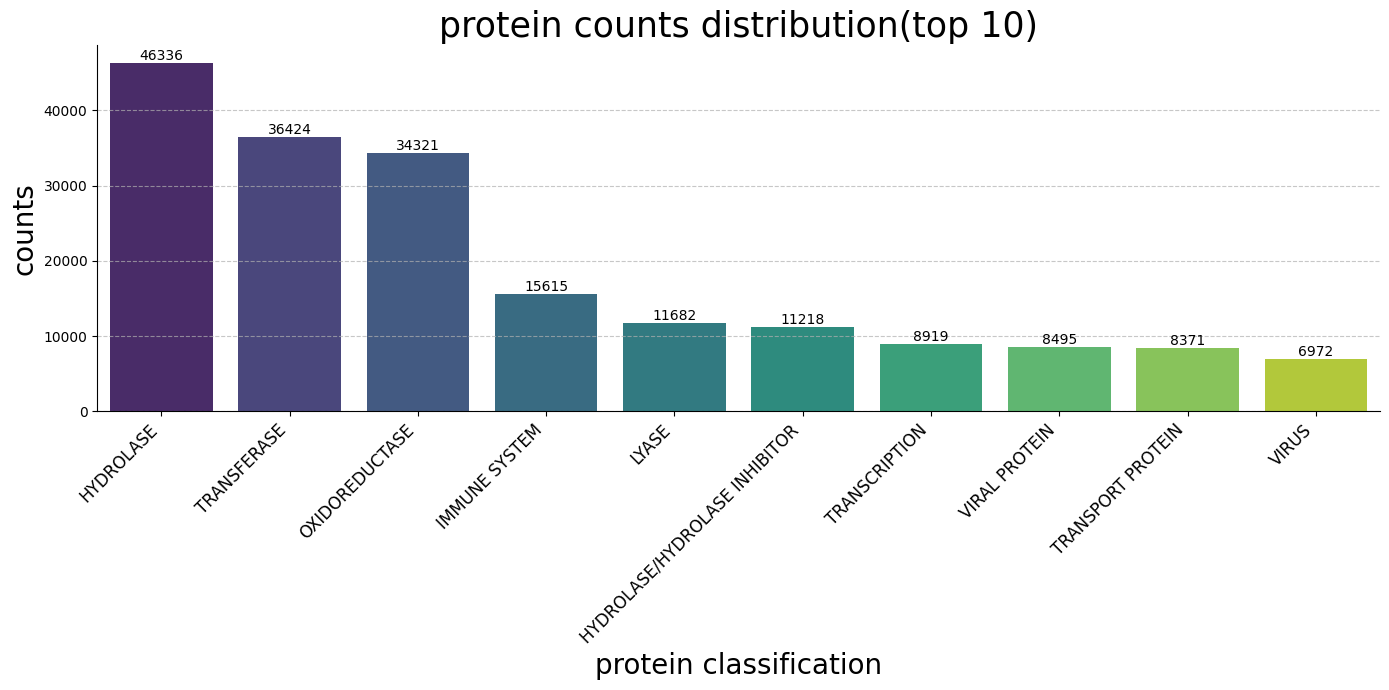

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
class_counts = df['classification'].value_counts()
top_n = 10
top_counts = class_counts.head(top_n)

plt.figure(figsize=(14, 7))
sns.barplot(x=top_counts.index, y=top_counts.values, palette='viridis')

plt.title(f'protein counts distribution(top {top_n})', fontsize=25)
plt.xlabel('protein classification', fontsize=20)
plt.ylabel('counts', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [3]:
import numpy as np
seq_lengths = [len(seq) for seq in sequences]

min_len = min(seq_lengths)
max_len = max(seq_lengths)
avg_len = sum(seq_lengths) / len(seq_lengths)

print(f"minimum: {min_len}")
print(f"maximum: {max_len}")
print(f"average: {avg_len:.2f}")

seq_lengths = [len(seq) for seq in sequences]
percentile_95 = np.percentile(seq_lengths, 95)
print(f'95% sequence length percentile: {percentile_95:.0f}')


minimum: 2
maximum: 5037
average: 294.53
95% sequence length percentile: 607


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


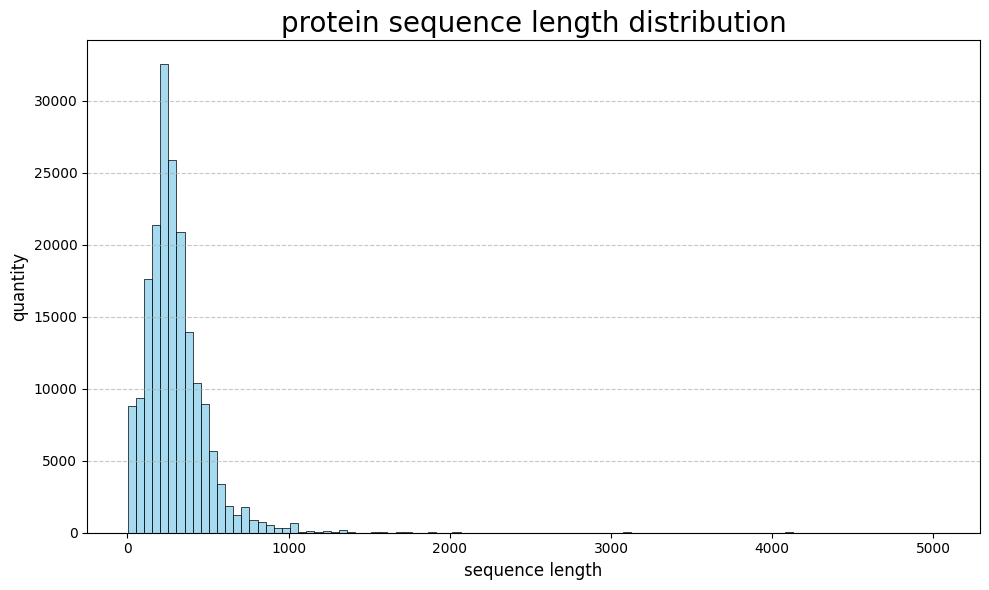

In [4]:
seq_lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(10,6))
sns.histplot(seq_lengths, bins=100, kde=False, color='skyblue')

plt.title('protein sequence length distribution', fontsize=20)
plt.xlabel('sequence length', fontsize=12)
plt.ylabel('quantity', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import numpy as np

# 1. 整数编码字典
MIN_LEN = 10
MAX_LEN = 600
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i+1 for i, aa in enumerate(amino_acids)}  # 0用于padding

def seq_to_int(seq):
    return torch.tensor([aa_to_int.get(aa, 0) for aa in seq], dtype=torch.long)

# 2. 自定义 Dataset
class ProteinDataset(Dataset):
    def __init__(self, sequences, labels):
        # 过滤过短序列和对应标签
        filtered = [(seq, label) for seq, label in zip(sequences, labels) if len(seq) >= MIN_LEN]
        self.sequences = [item[0] for item in filtered]
        self.labels = [item[1] for item in filtered]
        print(f"剔除长度小于{MIN_LEN}的序列后剩余样本数: {len(self.sequences)}")
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]
        # 截断长序列
        if len(seq) > MAX_LEN:
            seq = seq[:MAX_LEN]
        seq_tensor = seq_to_int(seq)
        return seq_tensor, label

# 3. Collate 函数，实现batch内padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return sequences_padded, lengths, labels

# 假设你已有序列和标签列表
# sequences = [...]
# labels_str = [...]

# 4. 标签编码
le = LabelEncoder()
labels = le.fit_transform(labels_str)

# 5. 划分训练集和测试集
seq_train, seq_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.1, random_state=42)

# 6. 创建 Dataset 和 DataLoader
train_dataset = ProteinDataset(seq_train, y_train)
test_dataset = ProteinDataset(seq_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# 7. 定义模型
class ProteinRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True) 
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.rnn(packed)  # hidden: (num_directions, batch, hidden_dim)
        hidden = torch.cat([hidden[0], hidden[1]], dim=1) # 拼接双向hidden: (batch, hidden_dim * 2)
        
        ## hidden shape: (num_layers * num_directions, batch, hidden_dim) 取最后一层hidden状态
        #hidden = hidden[-1]
        out = self.fc(hidden)
        return out

# 8. 参数定义
vocab_size = len(amino_acids) + 1
embed_dim = 128
hidden_dim = 256
output_dim = len(le.classes_)
epochs = 20
model = ProteinRNN(vocab_size, embed_dim, hidden_dim, output_dim)

# 9. 训练准备
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 10. 训练循环示范
for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_correct, train_total = 0, 0
    for batch_x, batch_len, batch_y in train_loader:
        batch_x, batch_len, batch_y = batch_x.to(device), batch_len.to(device), batch_y.to(device)
        optimizer.zero_grad()
        preds = model(batch_x, batch_len)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        outputs = preds.argmax(dim=1)
        train_correct += (outputs == batch_y).sum().item()
        train_total += outputs.shape[0]
    scheduler.step(loss)
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, '
         f'Train Accuracy: {100*train_correct/train_total:.2f}%')


剔除长度小于10的序列后剩余样本数: 167022
剔除长度小于10的序列后剩余样本数: 18536


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.9796, Train Accuracy: 67.16%
Epoch 2, Loss: 0.4566, Train Accuracy: 85.86%
Epoch 3, Loss: 0.3423, Train Accuracy: 89.30%
Epoch 4, Loss: 0.2892, Train Accuracy: 90.92%
Epoch 5, Loss: 0.2586, Train Accuracy: 91.75%
Epoch 6, Loss: 0.2310, Train Accuracy: 92.58%
Epoch 7, Loss: 0.2077, Train Accuracy: 93.25%
Epoch 8, Loss: 0.1394, Train Accuracy: 95.32%
Epoch 9, Loss: 0.1221, Train Accuracy: 95.87%
Epoch 10, Loss: 0.1186, Train Accuracy: 96.03%
Epoch 11, Loss: 0.1153, Train Accuracy: 96.07%
Epoch 12, Loss: 0.1114, Train Accuracy: 96.19%
Epoch 13, Loss: 0.1073, Train Accuracy: 96.33%
Epoch 14, Loss: 0.0869, Train Accuracy: 96.73%
Epoch 15, Loss: 0.0832, Train Accuracy: 96.75%
Epoch 16, Loss: 0.0809, Train Accuracy: 96.82%
Epoch 17, Loss: 0.0721, Train Accuracy: 97.06%
Epoch 18, Loss: 0.0702, Train Accuracy: 97.06%
Epoch 19, Loss: 0.0695, Train Accuracy: 97.08%
Epoch 20, Loss: 0.0686, Train Accuracy: 97.09%


Test Accuracy: 94.22%


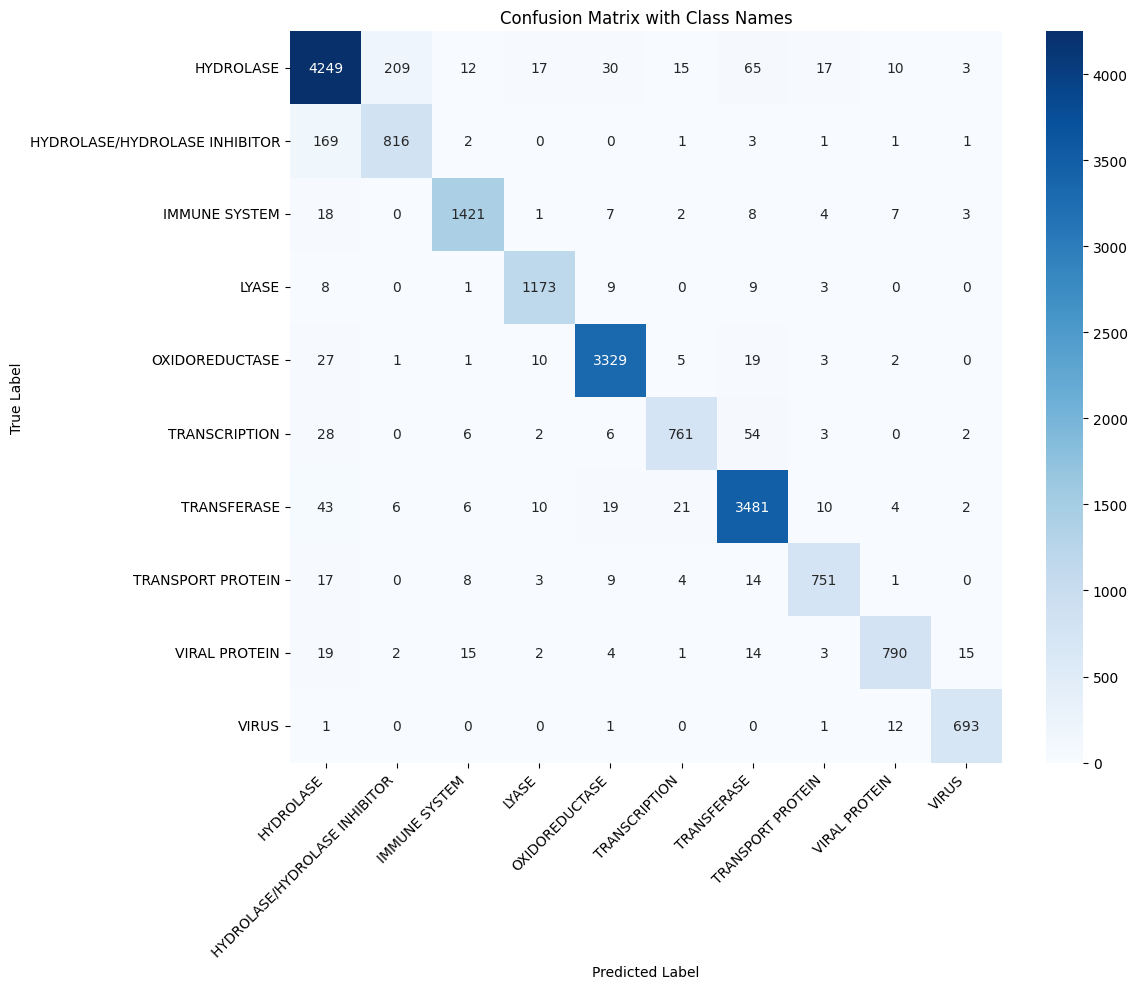

In [6]:
from sklearn.metrics import confusion_matrix

model.eval()
#test_correct, test_total = 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_x, batch_len, batch_y in test_loader:
        batch_x, batch_len, batch_y = batch_x.to(device), batch_len.to(device), batch_y.to(device)
        preds = model(batch_x, batch_len)
        _, outputs = torch.max(preds, 1)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print(f'Test Accuracy: {acc:.2f}%')
# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
# 类别名字（字符串）
class_names = le.classes_
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Class Names')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()